In [117]:
%load_ext autoreload
%autoreload 2

import json


import pymc as pm
import arviz as az

import numpy as np

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

# import aesara
import aesara.tensor as at
# from aesara.graph.op import Op
from aesara.link.jax.dispatch import jax_funcify

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp


# import sys
# sys.path.insert(1, '/Users/malinhorstmann/Documents/pyhf_pymc/src')
import MH_inference
import HMC_inference
import prepare_inference

import matplotlib.pyplot as plt

import pyhf
pyhf.set_backend('jax')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Model

In [82]:
### Simple pyhf model
model = pyhf.Model(
    {'channels': [{'name': 'singlechannel',
    'samples': [
    {'name': 'signal',
     'data': [6, 6, 60],
     'modifiers': [
         {'name': 'mu', 'type': 'normfactor', 'data': None}]},

    {'name': 'background',
     'data': [55, 55, 55],
     'modifiers': [
        ## Staterror / Normal
        {"name": "my_staterror","type": "staterror","data": [2.0, 2.0, 2.0],},
        ## Lumi / Normal
        {'name': 'lumi', 'type': 'lumi', 'data': None},
        ## Correlated / Normal
        {'name': 'corr_bkg', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg1', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        {'name': 'corr_bkg2', 'type': 'histosys','data': {'hi_data': [65, 56, 67], 'lo_data': [40, 40, 43]}},
        ## Uncorrelated / Poisson
        {'name': 'uncorr_bkg', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg1', 'type': 'shapesys','data': [7, 8, 7.17]},
        {'name': 'uncorr_bkg2', 'type': 'shapesys','data': [7, 8, 7.17]},
        
         ]},    
                                 
    ]},
    ]
    ,
    "parameters": [
            {
                "name": "lumi",
                "auxdata": [1.0],
                "sigmas": [0.017],
                "bounds": [[0.915, 1.085]],
                "inits": [1.0],
            }],
        }
)

obs = model.expected_actualdata(model.config.suggested_init())

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [13]:
# with open('SRee_SRmm_Srem.json') as serialized:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

obs = workspace.data(model, include_auxdata=False)

nBins = len(model.expected_actualdata(model.config.suggested_init()))
nPars = len(model.config.suggested_init())

In [83]:
# Prepare the priors for sampling
    # Unconstrained parameters
unconstr_dict = {
    'uncon1': {'type': 'unconstrained', 'type2': 'normal', 'input': [[1], [0.1]]}
    }

    # Create dictionary with all priors (unconstrained, constrained by normal and poisson)
prior_dict = prepare_inference.prepare_priors(model, unconstr_dict)

    # dictionary with keys 'model', 'obs', 'priors', 'precision'
prepared_model = prepare_inference.prepare_model(model=model, observations=obs, precision=1, priors=prior_dict)

## HMC

### General Stuff

In [84]:
# Jax expected data
@jax.jit
def processed_expData(parameters):
    a = jnp.stack([model.expected_actualdata(parameters)[i] for i in range(nBins)])
    return a

one_vector = np.full(nBins, 1., dtype='float64')

# Gradient list (dn_bins/dx_1, ..., dn_bins/dx_nPars)
@jax.jit
def vjp_expData(parameters):
    _,back = jax.vjp(processed_expData, parameters)
    return back(one_vector)

### Testing the gradient calculation
Calculating the derivatives by hand for MU and STAT_ERROR ONLY: n_binn = stat_error_n * 55 + mu * 6
- d/dmu = dn_bin1 / dmu + dn_bin2 / dmu + dn_bin3 / dmu = 6 + 6 + 60 = 72
- d/dstat_error_1 = dn_bin1 / dstat_error_1 + dn_bin2 / dstat_error_1 + dn_bin3 / dstat_error_1 = 55 + 0 +0
- d/dstat_error_2 = ... = 0 + 55 + 0
- d/dstat_error_3 = ... = 0 + 0 + 55

-> Looks right: (72, 55, 55, 55)

In [226]:
# Testing   
# ev_point = model.config.suggested_init()

    # Using my functions
# print(f'processed_expData(ev_point): {processed_expData(ev_point)}')
# print(f'vjp_expData(ev_point): {np.asarray(vjp_expData(ev_point)[0])}')

# print('.......')

    # By hand (attention, the jaconian is shape-inverted)
# print(f'jax.jacrev(processed_expData)(ev_point) @ one_vector: {jax.jacrev(processed_expData)(ev_point) @ one_vector}')

processed_expData(ev_point): [ 61.  61. 115.]
vjp_expData(ev_point): [72. 55. 55. 55.]
.......
jax.jacrev(processed_expData)(ev_point) @ one_vector: [72. 55. 55. 55.]


### Testing the order of the gradients and the order of the parameters

-> Also look good

In [239]:
# order of gradients is order of model.config.suggested_init()
# print(model.config.suggested_init())
# print(model.config.par_map.items())
# print(prior_dict)
# print(prepare_inference.get_target(model))

[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
dict_items([('corr_bkg', {'slice': slice(0, 1, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x15011df40>}), ('corr_bkg1', {'slice': slice(1, 2, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x1772ec340>}), ('corr_bkg2', {'slice': slice(2, 3, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x178ff05e0>}), ('lumi', {'slice': slice(3, 4, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_normal object at 0x17ad9c130>}), ('mu', {'slice': slice(4, 5, None), 'paramset': <pyhf.parameters.paramsets.unconstrained object at 0x15b07ed90>}), ('uncorr_bkg', {'slice': slice(5, 8, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_poisson object at 0x1693d18b0>}), ('uncorr_bkg1', {'slice': slice(8, 11, None), 'paramset': <pyhf.parameters.paramsets.constrained_by_poisson object at 0x1693d1640>}), ('uncor

### Gradient Op

In [169]:
class VJPOp(pt.Op):

    def make_node(self, parameters):
        # self.vjp_func = vjp_expData
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]
        
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters,) = inputs
        results = vjp_expData(parameters)

        if not isinstance(results, (list, tuple)):
                results = (results,)
                
        for i, r in enumerate(results):
            outputs[i][0] = np.asarray(r)

vjp_op = VJPOp()

### Non-Gradient Op (with `grad` method)

In [170]:
class ExpDataOp(pt.Op):
    
    def make_node(self, parameters):
        inputs = [pt.as_tensor_variable(parameters)]
        # inputs = [pt.vector()]
        outputs = [pt.vector()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = processed_expData(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
        for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)

    def grad(self, parameters):
        return [vjp_op(parameters)]
        

expData_op = ExpDataOp()

# pars = prepare_inference.priors2pymc(prepared_model)
    
# expData_op(pars).eval()

In [127]:
# class ExpDataOp_1(pt.Op):
    
#     def make_node(self, parameters):
#         # inputs = [pt.as_tensor_variable(parameters)]
#         inputs = [pt.vector()]
#         outputs = [pt.vector()]

#         return Apply(self, inputs, outputs)

#     def perform(self, node, inputs, outputs):
#         (parameters, ) = inputs
#         results = processed_expData(parameters)

#         if len(outputs) == 1:
#                 outputs[0][0] = np.asarray(results)
#                 return
#         for i, r in enumerate(results):
#                 outputs[i][0] = np.asarray(r)
    
#     def grad(self, parameters):
#         return [vjp_op(parameters)]

# expData_op_1 = ExpDataOp_1()

# # expData_op_1(model.config.suggested_init()).eval()

## Sampling Hamiltonian MC

In [171]:
print('... Parameter Sampling')
with pm.Model() as m:
    pars = prepare_inference.priors2pymc(prepared_model)
    # pars = model.config.suggested_init()
    # pm.sample()

print('... HMC Sampling:')

with m:
    expData_op = ExpDataOp()
    ExpData = pm.Normal("ExpData", mu=expData_op(pars), sigma=1, observed=obs)
    
    post_data = pm.sample(1500)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1500)

az.summary(post_pred, var_names="ExpData")



... Parameter Sampling
... HMC Sampling:


TypeError: grad() takes 2 positional arguments but 3 were given

## Sampling Metropolis-Hasting

In [103]:
with pm.Model():

        final = prepare_inference.priors2pymc(prepared_model)
        # final = model.config.suggested_init()

        mu = MH_inference.ExpDataOp('mainOp', processed_expData)
        ExpData = pm.Normal('ExpData', mu=mu(final), sigma=1, observed=obs)

        MetrHast_post_data = pm.sample(500)
        MetrHast_post_pred = pm.sample_posterior_predictive(MetrHast_post_data)
        MetrHast_prior_pred = pm.sample_prior_predictive(500)

print(model.expected_actualdata(model.config.suggested_init()))
az.summary(MetrHast_post_pred)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]
CompoundStep
>Metropolis: [Unconstrained]
>Metropolis: [Normals]
>Metropolis: [Gammas]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [ExpData, Gammas, Normals, Unconstrained]


[ 61.  61. 115.]


/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/stats/stats.py:1351: UserWarning: Selecting first found group: posterior_predictive
  warnings.warn(f"Selecting first found group: {data.groups()[0]}")


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ExpData[0],61.128,1.430,58.634,63.875,0.064,0.045,503.0,1028.0,1.00
ExpData[1],60.597,1.400,57.992,63.162,0.054,0.038,676.0,1001.0,1.00
ExpData[2],115.109,1.442,112.332,117.702,0.052,0.037,767.0,981.0,1.01


In [114]:
print('... Parameter Sampling')
with pm.Model() as m:
    pars = prepare_inference.priors2pymc(prepared_model)
    # pars = model.config.suggested_init()
    pm.sample()

print('... HMC Sampling:')

with m:
    expData_op_1 = ExpDataOp_1()
    ExpData_1 = pm.Normal("ExpData_1", mu=expData_op_1(pars).eval(), sigma=1, observed=obs)
    
    post_data = pm.sample(1500)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1500)

az.summary(post_data)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


... Parameter Sampling


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals, Gammas]
NUTS: [Unconstrained, Normals, Gammas]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


... HMC Sampling:


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Unconstrained, Normals, Gammas]


Sampling 4 chains for 1_000 tune and 1_500 draw iterations (4_000 + 6_000 draws total) took 2 seconds.


Sampling: [ExpData_1, Gammas, Normals, Unconstrained]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Unconstrained[0],0.999,0.101,0.812,1.192,0.001,0.001,9873.0,4498.0,1.0
Normals[0],0.009,0.994,-1.870,1.872,0.009,0.014,11784.0,4336.0,1.0
Normals[1],0.003,0.990,-1.912,1.852,0.010,0.014,10824.0,4392.0,1.0
Normals[2],0.000,1.006,-1.865,1.891,0.010,0.015,11016.0,4267.0,1.0
Normals[3],1.000,0.017,0.969,1.033,0.000,0.000,11060.0,4475.0,1.0
Normals[4],1.000,0.036,0.934,1.070,0.000,0.000,11021.0,4656.0,1.0
Normals[5],1.000,0.036,0.930,1.065,0.000,0.000,11203.0,4196.0,1.0
Normals[6],1.000,0.036,0.935,1.070,0.000,0.000,11334.0,4678.0,1.0
Gammas[0],1.000,0.002,0.996,1.004,0.000,0.000,11005.0,4305.0,1.0
Gammas[1],1.000,0.003,0.994,1.006,0.000,0.000,10615.0,4170.0,1.0


In [118]:
MetrHast_post_data, MetrHast_post_pred, MetrHast_prior_pred = MH_inference.sampling(prepared_model, 500)

print(model.expected_actualdata(model.config.suggested_init()))
az.summary(MetrHast_post_data)

NameError: name 'nBins' is not defined
Apply node that caused the error: ExpDataOp(MakeVector{dtype='float64'}.0)
Toposort index: 23
Inputs types: [TensorType(float64, (17,))]
Inputs shapes: [(17,)]
Inputs strides: [(8,)]
Inputs values: ['not shown']
Outputs clients: [[Elemwise{Composite{((i0 * sqr((i1 - i2))) - i3)}}(TensorConstant{(1,) of -0.5}, ExpData{[ 61.  61. 115.]}, ExpDataOp.0, TensorConstant{(1,) of 0...5332046727})]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/p9/sw_pjm3j027cxfs57s_91bfw0000gn/T/ipykernel_1110/3204394602.py", line 1, in <module>
    MetrHast_post_data, MetrHast_post_pred, MetrHast_prior_pred = MH_inference.sampling(prepared_model, 500)
  File "/Users/malinhorstmann/Documents/pyhf_pymc/src/pyhf_pymc/MH_inference.py", line 88, in sampling
    plt.legend(loc='upper left')
  File "/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pytensor/graph/op.py", line 296, in __call__
    node = self.make_node(*inputs, **kwargs)
  File "/Users/malinhorstmann/Documents/pyhf_pymc/src/pyhf_pymc/MH_inference.py", line 55, in make_node
    Output:

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [150]:
import MH_inference
test = MH_inference.ExpDataOp('test', processed_expData)
test(pars).eval

<bound method Variable.eval of ExpDataOp.0>

In [166]:
class ExpDataOp(pt.Op):
    """

    """
    # itypes = [pt.dvector]  
    # otypes = [pt.dvector]  

    def make_node(self, parameters):
        inputs = [pt.as_tensor_variable(parameters)]  
        outputs = [pt.dvector]  

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        ## Method that is used when calling the Op
        (pars,) = inputs  # Contains my variables

        ## Calling input function (in our case the model.expected_actualdata)
        result = processed_expData(pars)

        ## Output values of model.expected_actualdata
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

In [168]:
expData_op = ExpDataOp()
expData_op(model.config.suggested_init())

TypeError: The 'outputs' argument to Apply must contain Variable instances with no owner, not TensorType(float64, (?,))

## Plotting

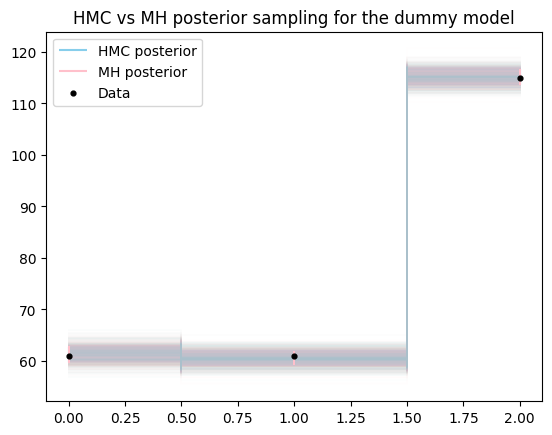

In [43]:
# plt.step(np.linspace(0,nBins-1,nBins),prior_pred.prior_predictive.main[0].T, alpha = 0.01, c = 'steelblue', where = 'mid');
# plt.vlines(np.arange(nBins),*np.quantile(prior_pred.prior_predictive.main[0],[.15,.85],axis=0), colors = 'steelblue', label='HMC prior');

    ## Posterior predictive
plt.step(np.linspace(0,nBins-1,nBins),post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'skyblue', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'skyblue', label='HMC posterior')

plt.step(np.linspace(0,nBins-1,nBins),MetrHast_post_pred.posterior_predictive.ExpData[0].T, alpha = 0.01, c = 'pink', where = 'mid');
plt.vlines(np.arange(nBins),*np.quantile(MetrHast_post_pred.posterior_predictive.ExpData[0],[.15,.85],axis=0), colors = 'pink', label='MH posterior')

    ## Observations
plt.scatter(np.arange(nBins), obs, c = 'k',s=12, zorder = 999, label = "Data")
plt.legend(loc='upper left')

plt.title(f'HMC vs MH posterior sampling for the dummy model')
# plt.title(f'HMC vs MH posterior sampling for ttbar')

plt.savefig(f'HMC_MH_dummy')
# plt.savefig(f'HMC_MH_ttbar')
plt.show()

## Inference Quality

In [ ]:
# az.plot_trace(post_data)
# plt.savefig("HMC_traces_DisplacedLeptons")
# az.plot_trace(MetrHast_post_data)
# plt.savefig("MH_traces_DisplacedLeptons")

# az.plot_autocorr(post_data)
# plt.savefig("HMC_autocorr_DisplacedLeptons")
# az.plot_autocorr(MetrHast_post_data)
# plt.savefig("MH_autocorr_DisplacedLeptons")

# az.plot_trace(post_data)
# plt.savefig("HMC_traces_dummy")
# az.plot_trace(MetrHast_post_data)
# plt.savefig("MH_traces_dummyr")

# az.plot_autocorr(post_data)
# plt.savefig("HMC_autocorr_dummy")
# az.plot_autocorr(MetrHast_post_data)
# plt.savefig("MH_autocorr_dummy")

In [119]:
@jax.jit
def processed_expData(parameters):
    a = jnp.stack([model.expected_actualdata(parameters)[i] for i in range(nBins)])
    return a

class ExpDataOp(pt.Op):
    
    def make_node(self, parameters):
        inputs = [pt.as_tensor_variable(parameters)]
        outputs = [pt.vector()]

        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (parameters, ) = inputs
        results = processed_expData(parameters)

        if len(outputs) == 1:
                outputs[0][0] = np.asarray(results)
                return
        for i, r in enumerate(results):
                outputs[i][0] = np.asarray(r)

In [122]:
exp_data_op = ExpDataOp()
exp_data_op(model.config.suggested_init()).eval()

array([ 61.,  61., 115.])